In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
#import gurobipy as gp
#from pyomo.environ import *

In [3]:
import pandas as pd
import zipfile
zip_path = r"C:\Users\mun93\PycharmProjects\JupyterProject\models\Resource_Assessment\hourly_data3.zip"
# Read CSV directly from the ZIP file
with zipfile.ZipFile(zip_path, 'r') as z:
    # List files in the zip
    print("Files in zip:", z.namelist())

    # Assuming there is one CSV file — or find it specifically
    csv_filename = [name for name in z.namelist() if name.endswith('.csv')][0]

    with z.open(csv_filename) as f:
        df = pd.read_csv(f, comment='#')

# Now `df` contains your data
a = pd.DataFrame(df)
a.head(5)

Files in zip: ['H_ERA5_ECMW_T639_WS-_0100m_Euro_NUT2_S197901010000_E202503312300_INS_TIM_01h_NA-_noc_org_NA_NA---_NA---_NA---.csv']


,Date,AL01,AL02,AL03,AT11,AT12,AT13,AT21,AT22,AT31,...,UKK3,UKK4,UKL1,UKL2,UKM5,UKM6,UKM7,UKM8,UKM9,UKN0
0,1979-01-01 00:00:00,7.772373,6.672618,5.454233,5.164603,5.202211,4.909172,2.688801,3.716716,4.461359,...,7.971570,8.111188,7.057331,7.309735,2.787610,5.614151,2.871535,2.383215,5.743454,3.506364
1,1979-01-01 01:00:00,7.432220,6.300089,5.171101,5.417057,5.168954,5.472977,2.699611,3.833968,4.827032,...,7.544292,7.859914,6.783741,7.054538,3.356556,6.294391,2.948044,2.272266,5.208310,3.003641
2,1979-01-01 02:00:00,6.906139,6.024628,4.893156,5.804094,5.298949,5.793530,2.407861,3.731827,5.178454,...,7.356775,7.788783,6.446888,6.694837,4.158256,6.574001,3.432486,2.418997,4.685642,2.759011
3,1979-01-01 03:00:00,6.313559,5.809914,4.659769,5.753984,6.078272,5.613207,2.361902,3.579651,7.007757,...,7.437146,7.876880,6.526186,6.807807,5.076037,6.583197,3.965686,2.679350,4.449539,2.811764
4,1979-01-01 04:00:00,5.401194,5.925399,4.480835,4.465773,7.323274,6.494917,2.455766,3.468159,9.195400,...,7.126097,7.589443,6.611962,7.018999,6.126894,6.508929,4.488028,3.247680,4.486164,3.178005


In [4]:
#print(a.columns)
de_filter_df = a.loc[:, a.columns.str.contains('DE|Date')]
de_filter_df
#print(de_filter_df.columns.size)

de_filter_df

de_melted = de_filter_df.melt(id_vars=['Date'], var_name='NUTS_ID', value_name='Wind_Speed')
de_melted['Year'] = pd.to_datetime(de_melted['Date']).dt.year


de_grouped = de_melted.groupby(['Year', 'NUTS_ID']).agg({'Wind_Speed': 'mean'}).reset_index()
de_grouped


,Year,NUTS_ID,Wind_Speed
0,1979,DE11,5.024517
1,1979,DE12,4.856583
2,1979,DE13,4.091072
3,1979,DE14,4.557628
4,1979,DE21,3.955205
...,...,...,...
1781,2025,DED4,5.438745
1782,2025,DED5,5.528848
1783,2025,DEE0,5.525501
1784,2025,DEF0,6.654412


In [5]:
from numpy.random import weibull
from scipy.stats import gamma
import pandas as Wind_Speed
import numpy as np
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

# Step 1: Group by NUTS_ID
Wind_Speed_scale_data = []
df = de_melted[(de_melted.Year >= 2004) & (de_melted.Year <= 2024)].dropna()
threshold = df['Wind_Speed'].quantile(1)
data_filtered = df[df['Wind_Speed'] <= threshold]

#print(df.isna().sum())
for (Year, region), group in data_filtered.groupby([ 'Year', 'NUTS_ID']):
    p_density = group['Wind_Speed'].values
    if len(p_density) >= 2:  # minimum data threshold
        #k, loc, scale = weibull_min.fit(p_density, floc=0)
        c, loc, scale = weibull_min.fit(p_density, floc=0)
        n_sample = len(p_density)
        Wind_Speed_scale_data.append({'Year': Year, 'NUTS_ID': region, 'scale': scale, 'n_sample': n_sample})

Wind_Speed_scale_df = Wind_Speed.DataFrame(Wind_Speed_scale_data)
print(Wind_Speed_scale_df.head(), "\n")
    
regional_Wind_Speed_scale_data = []
df = de_melted[(de_melted.Year >= 2004) & (de_melted.Year <= 2024)].dropna()
threshold = df['Wind_Speed'].quantile(1)
data_filtered = df[df['Wind_Speed'] <= threshold]

#print(df.isna().sum())
for (region), group in data_filtered.groupby([ 'NUTS_ID']):
    p_density = group['Wind_Speed'].values
    if len(p_density) >= 2:  # minimum data threshold
        #k, loc, scale = weibull_min.fit(p_density, floc=0)
        c, loc, scale = weibull_min.fit(p_density, floc=0)
        n_sample = len(p_density)
        regional_Wind_Speed_scale_data.append({'Year': Year, 'NUTS_ID': region, 'scale': scale, 'shape': c, 'n_sample': n_sample})

regional_Wind_Speed_scale_df = Wind_Speed.DataFrame(regional_Wind_Speed_scale_data)
regional_Wind_Speed_scale_df['NUTS_ID'] = regional_Wind_Speed_scale_df['NUTS_ID'].apply(lambda x: x[0] if isinstance(x, tuple) else x)

print(regional_Wind_Speed_scale_df.head(), "\n")

# Compute σₛ: std of scale per sector
sigma_s = Wind_Speed_scale_df.groupby('NUTS_ID')['scale'].std().rename('sigma_s')

sigma_s
sigma_df = Wind_Speed.DataFrame({'NUTS_ID': sigma_s.index, 'sigma_s': sigma_s.values})
sigma_df['90%_var'] = sigma_df['sigma_s'] * 1.645
print(sigma_df.head())


   Year NUTS_ID     scale  n_sample
0  2004    DE11  5.827121      8784
1  2004    DE12  5.688183      8784
2  2004    DE13  4.796545      8784
3  2004    DE14  5.409722      8784
4  2004    DE21  4.732065      8784 

   Year NUTS_ID     scale     shape  n_sample
0  2024    DE11  5.685196  2.113162    184102
1  2024    DE12  5.533943  2.053752    184102
2  2024    DE13  4.662840  1.895322    184102
3  2024    DE14  5.261829  1.975905    184102
4  2024    DE21  4.569881  2.050243    184102 

  NUTS_ID   sigma_s   90%_var
0    DE11  0.233403  0.383948
1    DE12  0.254599  0.418815
2    DE13  0.253400  0.416843
3    DE14  0.256323  0.421651
4    DE21  0.190814  0.313889


In [6]:
Wind_Speed_scale_df

,Year,NUTS_ID,scale,n_sample
0,2004,DE11,5.827121,8784
1,2004,DE12,5.688183,8784
2,2004,DE13,4.796545,8784
3,2004,DE14,5.409722,8784
4,2004,DE21,4.732065,8784
...,...,...,...,...
772,2024,DED4,6.344692,8784
773,2024,DED5,6.487861,8784
774,2024,DEE0,6.510096,8784
775,2024,DEF0,7.695993,8784


## perturbation factor

In [50]:
sectoral_joind = sigma_df.merge(regional_Wind_Speed_scale_df, on='NUTS_ID', how='left')
sectoral_joind['percentage_var'] = sectoral_joind['90%_var'] / sectoral_joind['scale']
sectoral_joind['perturbation_factor'] = sectoral_joind['sigma_s'] / sectoral_joind['scale']

sectoral_joind.head()

,NUTS_ID,sigma_s,90%_var,Year,scale,shape,n_sample,percentage_var,perturbation_factor
0,DE11,0.233403,0.383948,2024,5.685196,2.113162,184102,0.067535,0.041055
1,DE12,0.254599,0.418815,2024,5.533943,2.053752,184102,0.075681,0.046007
2,DE13,0.253400,0.416843,2024,4.662840,1.895322,184102,0.089397,0.054345
3,DE14,0.256323,0.421651,2024,5.261829,1.975905,184102,0.080134,0.048714
4,DE21,0.190814,0.313889,2024,4.569881,2.050243,184102,0.068686,0.041755


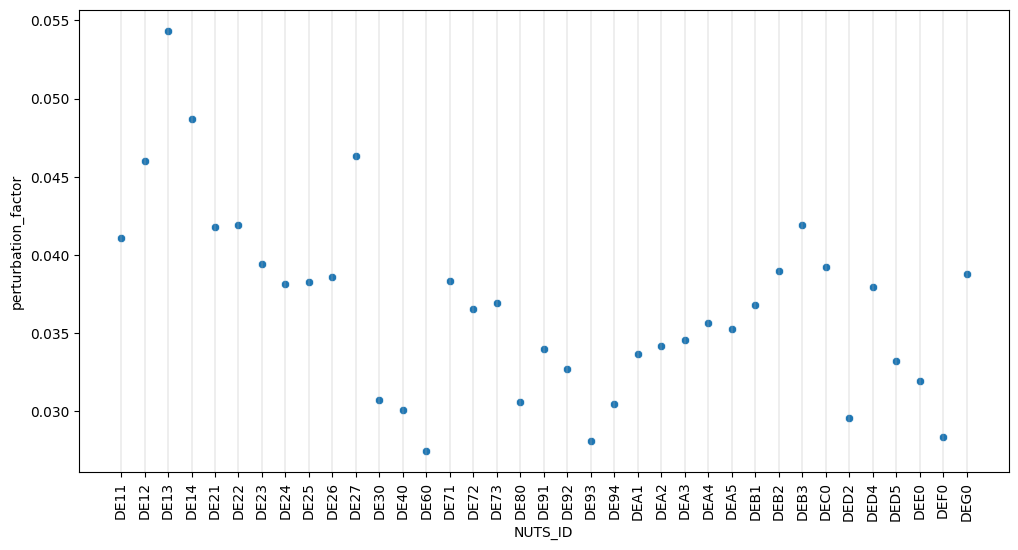

In [27]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sectoral_joind, x='NUTS_ID', y='perturbation_factor')
plt.xticks(rotation=90);
plt.grid(
    linewidth=0.3,
    axis="x"
)

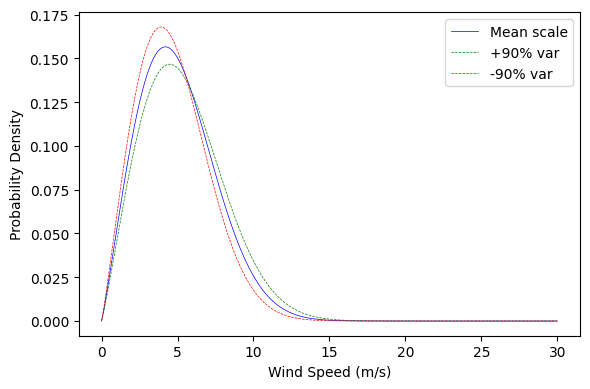

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Sector 0 parameters
sec = 0
shape = sectoral_joind['shape'][sec]  # shape parameter (k)
scale_mean = sectoral_joind['scale'][sec]
delta = sectoral_joind['90%_var'][sec]  # 90% variation (±)

# Weibull distributions
x = np.linspace(0, 30, 1000)
pdf_mean = weibull_min.pdf(x, c=shape, scale=scale_mean)
pdf_high = weibull_min.pdf(x, c=shape, scale=scale_mean + delta)
pdf_low  = weibull_min.pdf(x, c=shape, scale=max(scale_mean - delta, 0.1))  # avoid negative scale

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x, pdf_mean, label='Mean scale', color='blue', linewidth=.5)
plt.plot(x, pdf_high, label='+90% var', color='green', linestyle='--',linewidth=.5)
plt.plot(x, pdf_low, label='-90% var', color='red', linestyle='--', linewidth=.5)
#plt.title('Weibull Distribution – Sector 0 (Interannual Variability)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


<Axes: xlabel='Wind_Speed', ylabel='PC'>

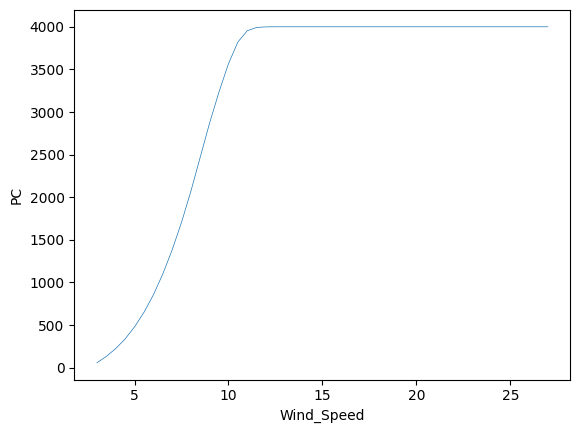

In [9]:
import seaborn as sns
power_curve = pd.read_csv(#r"C:\Users\mun93\Downloads\Vestas_V150_6.csv"
                          r"C:\Users\mun93\Downloads\Vestas_V136_4.csv"
                          )
power_curve.head()
sns.lineplot(data=power_curve, x='Wind_Speed', y='PC', linewidth=.5)

C:\Users\mun93\AppData\Local\Temp\ipykernel_1712\4145646071.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  60.47377471  139.81787879  236.8705928   355.74848032  503.69108554
  681.56118005  895.44535741 1148.21525911 1442.68586559 1777.43132858
 2154.10191401 2565.94810558 2975.12369492 3342.00456151 3668.44762039
 3916.06665339 4034.32342222 4049.34308758]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  perturbed[mask] = pc_power[mask] * (1 + (base_factor - 1) * weight)
C:\Users\mun93\AppData\Local\Temp\ipykernel_1712\4145646071.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  45.14418119  105.3179719   180.07331245  273.01237725  390.31761391
  533.45737617  708.13612454  917.79194018 1166.05628555 1453.38255944
 1782.96438668 2151.35982883 2528.8699024  2883.037

<Axes: xlabel='Wind_Speed', ylabel='PC'>

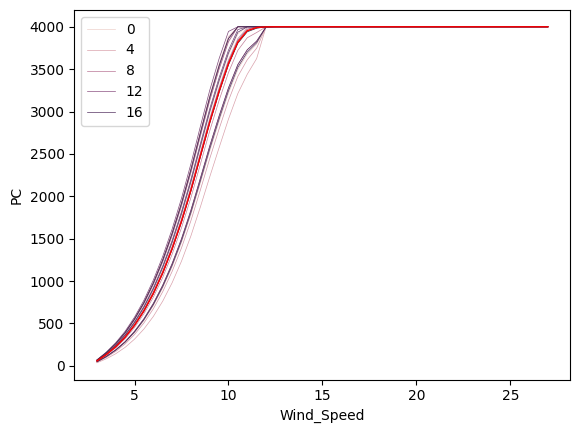

In [10]:
rng = np.random.default_rng(42)
def perturb_power_curve(pc_speeds, pc_power, rng, scale=0.2, alpha=.5):
    """
    Perturb power curve in partial load (3–12 m/s).
    Larger improvement at low speeds, tapering towards rated.
    Keeps rated power constant.
    """
    perturbed = pc_power.copy()
    p_rated = pc_power.max()

    # sample random factor
    base_factor = rng.normal(loc=1.0, scale=scale)
    base_factor = max(0, base_factor)

    mask = (pc_speeds >= 3) & (pc_speeds < 12)
    # weight: strong near 3 m/s, fades near 12 m/s
    frac = (pc_speeds[mask] - 3) / (12 - 3)
    weight = (1 - frac) ** alpha

    perturbed[mask] = pc_power[mask] * (1 + (base_factor - 1) * weight)

    # cap at rated
    perturbed = np.minimum(perturbed, p_rated)
    return perturbed



sample_list = []

for i in range(20):
    new = perturb_power_curve(power_curve['Wind_Speed'], power_curve['PC'], rng)
    df_tmp = pd.DataFrame({
        'Wind_Speed': power_curve['Wind_Speed'],
        'PC': new,
        'Sample_ID': i
    })
    sample_list.append(df_tmp)

sample_pc = pd.concat(sample_list, ignore_index=True)
sample_pc

sns.lineplot(data=sample_pc, x='Wind_Speed', y='PC', hue='Sample_ID', linewidth=.5, color='grey')
sns.lineplot(data=power_curve, x='Wind_Speed', y='PC', linewidth=1, color='red')

In [11]:
import pandas as pd

# Load WTG layout
wtg_layout = pd.read_csv(r"C:\Users\mun93\PycharmProjects\JupyterProject\models\Resource_Assessment\wind_direction_hourly\wtg_layout_2000-2024_Windpark Haren-Rütenmoor_updated.csv"
    #r"C:\Users\mun93\PycharmProjects\JupyterProject\models\Resource_Assessment\wind_direction_hourly\wtg_layout_2000-2024_Windpark Haren-Rütenmoor.csv"
    #r"C:\Users\mun93\PycharmProjects\JupyterProject\models\Resource_Assessment\wind_direction_hourly\wtg_layout_2000-2024_Windpark_Utgast.csv"
    #r"C:\Users\mun93\PycharmProjects\JupyterProject\models\Resource_Assessment\wind_direction_hourly\optimized_wtg_layout.csv"
     )

# Example columns expected: ['Latitude', 'Longitude']
wtg_layout.head()

from pyproj import Proj, Transformer

# Define a projection (e.g., UTM zone 32N for Germany)
transformer = Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)

wtg_layout[['X', 'Y']] = wtg_layout.apply(
    lambda row: pd.Series(transformer.transform(row['Longitude'], row['Latitude'])),
    axis=1
)
print("turbine_count = ", len(wtg_layout))
wtg_layout[['Longitude', 'Latitude', 'X', 'Y']].head()


turbine_count =  32


,Longitude,Latitude,X,Y
0,7.124773,52.876819,373801.070165,5.860215e+06
1,7.130610,52.876458,374192.756509,5.860164e+06
2,7.151694,52.869214,375590.862586,5.859322e+06
3,7.126006,52.870648,373866.088572,5.859526e+06
4,7.151738,52.863755,375578.185284,5.858715e+06


In [61]:
import numpy as np
import pandas as pd
from typing import Tuple
from tqdm import tqdm 
from scipy.stats import beta

def _interp_power(speeds, pc_speeds, pc_power):
    """Interpolate turbine power curve (kW) for given wind speeds."""
    return np.interp(speeds, pc_speeds, pc_power)

def aep_from_weibull_by_nuts_mc(
    sectoral_joind: pd.DataFrame,
    wtg_layout: pd.DataFrame,
    wtg_power_curve_df: pd.DataFrame,
    n_mc: int = 10000,
    hours_per_year: int = 8760,
    seed: int = 42,
    use_lognormal_scale: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Monte Carlo AEP by NUTS region using Weibull fits and multiplicative scale perturbation.
    Each MC run generates a synthetic year of 8760 wind speeds per NUTS_ID.

    Parameters
    ----------
    sectoral_joind : DataFrame with columns:
        ['NUTS_ID','Year','scale','shape','n_sample','perturbation_factor']
    wtg_layout : DataFrame with turbine positions (len = number of turbines)
    wtg_power_curve_df : DataFrame with ['Wind_Speed','PC'] in kW
    n_mc : number of Monte Carlo replicates
    hours_per_year : usually 8760 or 8784
    seed : RNG seed
    use_lognormal_scale : True → multiplicative lognormal perturbation on scale
                          False → Gaussian multiplicative perturbation

    Returns
    -------
    mc_results : DataFrame of all MC results (per run, per NUTS_ID)
    summary    : DataFrame of aggregated stats per NUTS_ID
    """
    # Sort power curve just in case
    pc = wtg_power_curve_df.sort_values('Wind_Speed')
    pc_speeds = pc['Wind_Speed'].to_numpy()
    pc_power  = pc['PC'].to_numpy()  # kW

    n_turbines = len(wtg_layout)
    p_rated_MW = pc_power.max() / 1000.0
    installed_capacity_MW = n_turbines * p_rated_MW

    rng = np.random.default_rng(seed)
    out_rows = []

    for _, r in sectoral_joind.iterrows():
        nuts = r['NUTS_ID']
        year = int(r['Year'])
        lam  = float(r['scale'])
        k    = float(r['shape'])
        pf   = float(r['perturbation_factor'])

        for mc in tqdm(range(n_mc), desc="MC Iterations", leave=False):

            availability_samples = beta.rvs(a=2, b=5, loc=0.92, scale=0.06,  random_state=rng)
            pc_power_mc = perturb_power_curve(pc_speeds, pc_power, rng, scale=0.2, alpha=0.5)

            # Perturb scale
            if use_lognormal_scale:
                lam_mc = lam * rng.lognormal(mean=0.0, sigma=pf)
            else:
                lam_mc = lam * (1.0 + pf * rng.standard_normal())
                lam_mc = max(lam_mc, 1e-6)

            # Draw 8760 synthetic hourly wind speeds
            speeds = rng.weibull(a=k, size=hours_per_year) * lam_mc



            # Turbine power (kW) for each hour
            p_turb_kW = _interp_power(speeds, pc_speeds, pc_power_mc)
            

            # Farm energy (MWh)
            aep_mwh = (p_turb_kW.sum() * n_turbines)  * availability_samples / 1000.0

            # Full-load hours
            flh = aep_mwh / installed_capacity_MW

            out_rows.append({
                'NUTS_ID': nuts,
                'Year': year,
                'mc_id': mc,
                'shape': k,
                'scale_base': lam,
                'scale_draw': lam_mc,
                'perturbation_factor': pf,
                'n_turbines': n_turbines,
                'installed_capacity_MW': installed_capacity_MW,
                'AEP_MWh': aep_mwh,
                'FLH': flh,
                'Availability': availability_samples
            })

    mc_results = pd.DataFrame(out_rows)

    # Per-NUTS summary
    summary = (
        mc_results
        .groupby(['NUTS_ID', 'Year'])
        .agg(
            AEP_MWh_mean=('AEP_MWh', 'mean'),
            AEP_MWh_median=('AEP_MWh', 'median'),
            AEP_MWh_p10=('AEP_MWh', lambda x: np.percentile(x, 10)),
            AEP_MWh_p90=('AEP_MWh', lambda x: np.percentile(x, 90)),
            AEP_MWh_std=('AEP_MWh', 'std'),
            FLH_mean=('FLH', 'mean'),
            FLH_median=('FLH', 'median'),
            FLH_p10=('FLH', lambda x: np.percentile(x, 10)),
            FLH_p90=('FLH', lambda x: np.percentile(x, 90)),
            n_mc=('mc_id', 'nunique')
        )
        .reset_index()
    )

    return mc_results, summary

#example:
mc_results, summary = aep_from_weibull_by_nuts_mc(sectoral_joind, wtg_layout, power_curve)

In [62]:
mc_results#.Availability.plot()

,NUTS_ID,Year,mc_id,shape,scale_base,scale_draw,perturbation_factor,n_turbines,installed_capacity_MW,AEP_MWh,FLH,Availability
0,DE11,2024,0,2.113162,5.685196,5.389244,0.041055,32,128.0,138374.253568,1081.048856,0.934637
1,DE11,2024,1,2.113162,5.685196,5.897646,0.041055,32,128.0,279761.880591,2185.639692,0.926179
2,DE11,2024,2,2.113162,5.685196,5.748216,0.041055,32,128.0,230350.734498,1799.615113,0.931502
3,DE11,2024,3,2.113162,5.685196,5.886784,0.041055,32,128.0,302317.963841,2361.859093,0.958555
4,DE11,2024,4,2.113162,5.685196,5.743133,0.041055,32,128.0,235619.391891,1840.776499,0.934780
...,...,...,...,...,...,...,...,...,...,...,...,...
369995,DEG0,2024,9995,2.266526,6.240885,6.089267,0.038769,32,128.0,262635.169382,2051.837261,0.933992
369996,DEG0,2024,9996,2.266526,6.240885,6.360321,0.038769,32,128.0,329264.391022,2572.378055,0.933182
369997,DEG0,2024,9997,2.266526,6.240885,6.386537,0.038769,32,128.0,280181.096881,2188.914819,0.936965
369998,DEG0,2024,9998,2.266526,6.240885,5.973669,0.038769,32,128.0,227699.398172,1778.901548,0.925034


In [198]:
summary.head()#.FLH_mean.plot()

optimal_capacity_MW                   LCoH_EUR_per_kg             \
                       mean std    min    max            mean std    min   
NUTS_ID                                                                    
DE11                  7.320 NaN  7.320  7.320           6.697 NaN  6.697   
DE12                  7.320 NaN  7.320  7.320           6.593 NaN  6.593   
DE13                  9.204 NaN  9.204  9.204           7.542 NaN  7.542   
DE14                  7.320 NaN  7.320  7.320           6.661 NaN  6.661   
DE21                  9.204 NaN  9.204  9.204           7.335 NaN  7.335   

               demand_met_ratio electrolyzer_utilization wind_sufficiency  
           max             mean                     mean         <lambda>  
NUTS_ID                                                                    
DE11     6.697            0.974                    0.723             full  
DE12     6.593            1.005                    0.746             full  
DE13     7.542            0.979                    0.578             full  
DE14     6.661            0.985                    0.731             full  
DE21     7.335            1.030                    0.608             full

In [64]:
mc_results.to_parquet(r"C:\Users\mun93\My_VS_codes\Resource_Assessment_VS\AEP_mc_results_for_LCoH_calcuations.parquet")
mc_results.to_clipboard()

In [66]:
MC_data = pd.read_parquet(r"C:\Users\mun93\My_VS_codes\Resource_Assessment_VS\AEP_mc_results_for_LCoH_calcuations.parquet")
MC_data 


,NUTS_ID,Year,mc_id,shape,scale_base,scale_draw,perturbation_factor,n_turbines,installed_capacity_MW,AEP_MWh,FLH,Availability
0,DE11,2024,0,2.113162,5.685196,5.389244,0.041055,32,128.0,138374.253568,1081.048856,0.934637
1,DE11,2024,1,2.113162,5.685196,5.897646,0.041055,32,128.0,279761.880591,2185.639692,0.926179
2,DE11,2024,2,2.113162,5.685196,5.748216,0.041055,32,128.0,230350.734498,1799.615113,0.931502
3,DE11,2024,3,2.113162,5.685196,5.886784,0.041055,32,128.0,302317.963841,2361.859093,0.958555
4,DE11,2024,4,2.113162,5.685196,5.743133,0.041055,32,128.0,235619.391891,1840.776499,0.934780
...,...,...,...,...,...,...,...,...,...,...,...,...
369995,DEG0,2024,9995,2.266526,6.240885,6.089267,0.038769,32,128.0,262635.169382,2051.837261,0.933992
369996,DEG0,2024,9996,2.266526,6.240885,6.360321,0.038769,32,128.0,329264.391022,2572.378055,0.933182
369997,DEG0,2024,9997,2.266526,6.240885,6.386537,0.038769,32,128.0,280181.096881,2188.914819,0.936965
369998,DEG0,2024,9998,2.266526,6.240885,5.973669,0.038769,32,128.0,227699.398172,1778.901548,0.925034


In [12]:
# Electrolyser techno-economics
lifetime = 20  # years
elect_capex_per_mw = 2.5e6
elect_opex_per_mw_per_year = 0.03 * elect_capex_per_mw
elect_efficiency_MWhH2_per_MWhe = 0.7      # MWh_H2 per MWh_e
annual_demand_kg = 9_453_600
replacement_year = lifetime // 2            # index [0..lifetime-1]
degradation_per_year = 0.01
opex_escalation_elec = 0.015
disc_elec = 0.07


In [70]:
%pip install gurobipy pyomo

  Using cached ply-3.11-py2.py3-none-any.whl.metadata (844 bytes)
   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   -- ------------------------------------- 0.3/3.9 MB ? eta -:--:--
   ---------------- ----------------------- 1.6/3.9 MB 4.7 MB/s eta 0:00:01
   ----------------------------------- ---- 3.4/3.9 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 3.9/3.9 MB 6.4 MB/s eta 0:00:00
Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
Note: you may need to restart the kernel to use updated packages.


In [71]:
import gurobipy as gp
from pyomo.environ import *
m = gp.Model()
solver = SolverFactory('gurobi', executable=r"C:\gurobi1203\win64\bin\gurobi_cl.exe")
print("Gurobi works correctly!")

Gurobi works correctly!


## hourly KW profile

In [51]:
import numpy as np
import pandas as pd
from typing import Tuple
from tqdm import tqdm
from scipy.stats import beta

def _interp_power(speeds, pc_speeds, pc_power):
    """Interpolate turbine power curve (kW) for given wind speeds."""
    return np.interp(speeds, pc_speeds, pc_power)

def hourly_wind_power_by_nuts_mc(
    sectoral_joind: pd.DataFrame,
    wtg_layout: pd.DataFrame,
    wtg_power_curve_df: pd.DataFrame,
    n_mc: int = 1000,
    hours_per_year: int = 8760,
    seed: int = 42,
    use_lognormal_scale: bool = False,
) -> pd.DataFrame:
 
    # Prepare power curve (kW per turbine)
    pc = wtg_power_curve_df.sort_values('Wind_Speed')
    pc_speeds = pc['Wind_Speed'].to_numpy()
    pc_power_kw = pc['PC'].to_numpy()  # kW per turbine

    # Farm sizing
    n_turbines = len(wtg_layout)
    p_rated_MW = pc_power_kw.max() / 1000.0
    installed_capacity_MW = n_turbines * p_rated_MW

    rng = np.random.default_rng(seed)
    rows = []

    for _, r in sectoral_joind.iterrows():
        nuts = r['NUTS_ID']
        lam  = float(r['scale'])
        k    = float(r['shape'])
        pf   = float(r['perturbation_factor'])

        for mc in tqdm(range(n_mc), desc=f"NUTS {nuts}", leave=False):
            # Availability draw (unitless multiplier, ~0.92–0.98 with given params)
            avail = beta.rvs(a=2, b=5, loc=0.92, scale=0.06, random_state=rng)
            pc_power_mc = perturb_power_curve(pc_speeds, pc_power_kw, rng, scale=0.2, alpha=0.5)

            # Scale perturbation
            if use_lognormal_scale:
                sigma_log = np.sqrt(np.log(1 + pf**2))
                lam_mc = lam * rng.lognormal(mean=0.0, sigma=sigma_log)
            else:
                lam_mc = lam * (1.0 + pf * rng.standard_normal())
                lam_mc = max(lam_mc, 1e-6)

            # Hourly wind speeds and per-turbine power (kW)
            speeds = rng.weibull(a=k, size=hours_per_year) * lam_mc
            p_turb_kw = _interp_power(speeds, pc_speeds, pc_power_mc)

            # Farm power time series (MW), applying availability multiplicatively
            power_MW = (p_turb_kw * n_turbines) * avail / 1000.0  # vector, length hours_per_year

            rows.append({
                'NUTS_ID': nuts,
                'mc_id': mc,
                'power_MW': power_MW,                       # np.ndarray
                'availability': avail,
                'perturbation_factor': pf,
                'power_curve': pc_power_mc,
                'installed_capacity_MW': installed_capacity_MW
            })

    return pd.DataFrame(rows)

# example:
one_year_hourly_df = hourly_wind_power_by_nuts_mc(sectoral_joind, wtg_layout, power_curve, n_mc=500)
one_year_hourly_df.head()


,NUTS_ID,mc_id,power_MW,availability,perturbation_factor,power_curve,installed_capacity_MW
0,DE11,0,"[20.943847134570184, 71.25332424133018, 1.0168...",0.934637,0.041055,"[34, 81, 141, 216, 313, 433, 581, 761, 978, 12...",128.0
1,DE11,1,"[2.133915417657893, 8.569167357237333, 26.2900...",0.926179,0.041055,"[72, 167, 283, 422, 595, 801, 1047, 1335, 1667...",128.0
2,DE11,2,"[21.53604314325105, 1.7586759108448367, 41.606...",0.931502,0.041055,"[59, 137, 233, 350, 496, 671, 882, 1132, 1424,...",128.0
3,DE11,3,"[42.30054441867012, 2.4232276687473573, 2.4232...",0.958555,0.041055,"[79, 182, 306, 457, 643, 864, 1126, 1432, 1784...",128.0
4,DE11,4,"[1.7947781484380472, 40.14162661146473, 1.7947...",0.934780,0.041055,"[60, 139, 236, 354, 502, 679, 893, 1145, 1439,...",128.0


## 20 years kw profile

In [157]:
import numpy as np
import pandas as pd
from typing import Tuple, List
from tqdm import tqdm
from scipy.stats import beta

def _interp_power(speeds, pc_speeds, pc_power):
    """Interpolate turbine power curve (kW) for given wind speeds."""
    return np.interp(speeds, pc_speeds, pc_power)

def hourly_wind_power_by_nuts_mc(
    sectoral_joind: pd.DataFrame,
    wtg_layout: pd.DataFrame,
    wtg_power_curve_df: pd.DataFrame,
    n_mc: int = 1000,
    years: int = 20,  # NEW: Number of years to simulate
    hours_per_year: int = 8760,
    seed: int = 42,
    use_lognormal_scale: bool = True,
) -> pd.DataFrame:
 
    # Prepare power curve (kW per turbine)
    pc = wtg_power_curve_df.sort_values('Wind_Speed')
    pc_speeds = pc['Wind_Speed'].to_numpy()
    pc_power_kw = pc['PC'].to_numpy()  # kW per turbine

    # Farm sizing
    n_turbines = len(wtg_layout)
    p_rated_MW = pc_power_kw.max() / 1000.0
    installed_capacity_MW = n_turbines * p_rated_MW

    rng = np.random.default_rng(seed)
    rows = []

    for _, r in sectoral_joind.iterrows():
        nuts = r['NUTS_ID']
        lam  = float(r['scale'])
        k    = float(r['shape'])
        pf   = float(r['perturbation_factor'])

        for mc in tqdm(range(n_mc), desc=f"NUTS {nuts}", leave=False):
            # Availability draw (unitless multiplier, ~0.92–0.98 with given params)
            avail = beta.rvs(a=2, b=5, loc=0.92, scale=0.06, random_state=rng)
            pc_power_mc = perturb_power_curve(pc_speeds, pc_power_kw, rng, scale=0.2, alpha=0.5)

            # Scale perturbation - FIXED for this MC run (represents climate)
            if use_lognormal_scale:
                sigma_log = np.sqrt(np.log(1 + pf**2))
                lam_mc = lam * rng.lognormal(mean=0.0, sigma=sigma_log)
            else:
                lam_mc = lam * (1.0 + pf * rng.standard_normal())
                lam_mc = max(lam_mc, 1e-6)

            # NEW: Generate 20 years of hourly data for this MC run
            all_years_power_MW = []
            
            for year in range(years):
                # Generate unique hourly wind speeds for each year (represents weather)
                speeds = rng.weibull(a=k, size=hours_per_year) * lam_mc
                p_turb_kw = _interp_power(speeds, pc_speeds, pc_power_mc)
                
                # Farm power time series (MW) for this year
                power_MW = (p_turb_kw * n_turbines) * avail / 1000.0
                all_years_power_MW.append(power_MW)

            # Combine all years into a single array
            full_timeseries_power_MW = np.concatenate(all_years_power_MW)

            rows.append({
                'NUTS_ID': nuts,
                'mc_id': mc,
                'power_MW': full_timeseries_power_MW,        # Now contains 20*8760 hours
                'availability': avail,
                'perturbation_factor': pf,
                'power_curve': pc_power_mc,
                'installed_capacity_MW': installed_capacity_MW,
                'lam_mc': lam_mc,  # Useful to track the perturbed scale
                'total_hours': years * hours_per_year  # Helpful metadata
            })

    return pd.DataFrame(rows)

# Example usage - now each row contains 175,200 hours (20 years)
twenty_year_hourly_df = hourly_wind_power_by_nuts_mc(sectoral_joind, wtg_layout, power_curve, n_mc=500, years=20)
twenty_year_hourly_df.head()

,NUTS_ID,mc_id,power_MW,availability,perturbation_factor,power_curve,installed_capacity_MW,lam_mc,total_hours
0,DE11,0,"[21.046489903332173, 71.5408338410659, 1.01688...",0.934637,0.041055,"[34, 81, 141, 216, 313, 433, 581, 761, 978, 12...",128.0,5.389366,175200
1,DE11,1,"[2.0248765245455016, 5.043073609970037, 28.503...",0.944439,0.041055,"[67, 155, 262, 393, 555, 748, 980, 1252, 1568,...",128.0,5.610071,175200
2,DE11,2,"[23.35231535335369, 64.98441852452174, 8.42484...",0.920316,0.041055,"[35, 84, 145, 222, 320, 442, 592, 776, 995, 12...",128.0,5.679566,175200
3,DE11,3,"[35.099654352571164, 38.225210690913045, 81.54...",0.945176,0.041055,"[47, 110, 188, 285, 406, 555, 735, 951, 1206, ...",128.0,5.689179,175200
4,DE11,4,"[21.008358648820735, 15.989513797237409, 10.75...",0.925189,0.041055,"[52, 121, 206, 310, 442, 601, 793, 1023, 1292,...",128.0,5.645327,175200


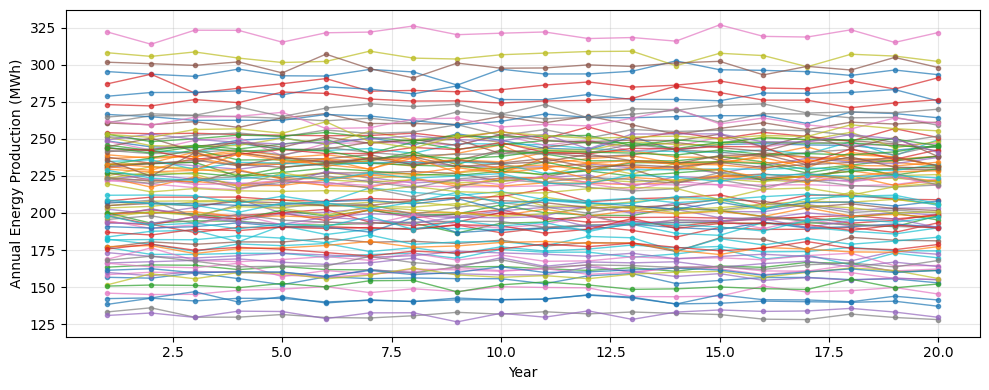

In [55]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))

for _, row in twenty_year_hourly_df[twenty_year_hourly_df['NUTS_ID'] == 'DE11'].iterrows():
    # Reshape the hourly data into years
    hourly_power = row['power_MW']
    annual_power = hourly_power.reshape(20, 8760).sum(axis=1)  # Sum hours for each year
    
    # Convert to GWh for better readability
    annual_energy_GWh = annual_power/1000  # MW*hours = MWh, /1000 = GWh
    # Actually, since power_MW is already in MW, and we sum hours:
    # annual_energy_GWh = annual_power / 1000  # Uncomment if you want GWh
    
    # Plot this MC run
    plt.plot(range(1, 20 + 1), annual_energy_GWh, 
            marker='o', markersize=3, linewidth=1, alpha=0.7,
            label=f'MC {row["mc_id"]} (λ={row.get("lam_mc", "N/A"):.2f})')

plt.xlabel('Year')
plt.ylabel('Annual Energy Production (MWh)')  # or 'GWh' if you converted

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## solve

In [215]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# ---------------- CONFIG ----------------
lifetime = 20
annual_demand_kg = 9_453_600 * 0.6  # target H2 demand per year

# Tech-econ params
elect_capex_per_mw = 2.5e6
elect_opex_per_mw_per_year = 0.03 * elect_capex_per_mw
wind_capex_per_mw = 1.3e6 
wind_opex_per_mw_per_year = 0.03 * wind_capex_per_mw

elect_efficiency_MWhH2_per_MWhe = 0.70
degradation_per_year = 0.01
opex_escalation = 0.015
disc_rate = 0.02

H2_MWh_per_ton = 39.39
H2_MWh_per_kg = H2_MWh_per_ton / 1000.0

# Precompute discount factors
df = np.array([1.0 / ((1.0 + disc_rate) ** (t+1)) for t in range(lifetime)])
df_opex = np.array([(1+opex_escalation)**t * df[t] for t in range(lifetime)])
df_deg = np.array([(1-degradation_per_year)**t * df[t] for t in range(lifetime)])
rep_df = df[lifetime // 2]

# ---------------- MODEL ----------------
def optimize_site(wind_profile_unit: np.ndarray, site_id="site"):
    """
    wind_profile_unit: hourly array (0-1), already normalized by max wind output
    """

    H = len(wind_profile_unit)
    if H == 0:
        return {"status":"infeasible", "site":site_id}

    # Pyomo model
    m = pyo.ConcreteModel()
    m.H = pyo.RangeSet(0, H-1)

    # Params
    m.wind = pyo.Param(m.H, initialize=dict(enumerate(wind_profile_unit)))

    # Decision variables
    m.E_cap = pyo.Var(within=pyo.NonNegativeReals)   # electrolyser MW
    m.W_cap = pyo.Var(within=pyo.NonNegativeReals)   # wind farm MW
    m.x = pyo.Var(m.H, within=pyo.NonNegativeReals)  # electrolyser hourly dispatch (MWhe)

    # Constraint: wind overbuild ratio
    m.wind_overbuild = pyo.Constraint(rule=lambda m: m.W_cap <= 3.0 * m.E_cap)

    # Hourly dispatch ≤ electrolyser capacity
    m.elec_cap = pyo.Constraint(m.H, rule=lambda m,h: m.x[h] <= m.E_cap)

    # Hourly dispatch ≤ available wind (scaled by W_cap)
    m.wind_cap = pyo.Constraint(m.H, rule=lambda m,h: m.x[h] <= m.wind[h]*m.W_cap)

    # Annual H2 production constraint
    annual_H2_MWh = elect_efficiency_MWhH2_per_MWhe * sum(m.x[h] for h in m.H)
    m.annual_H2 = pyo.Constraint(expr=annual_H2_MWh == annual_demand_kg * H2_MWh_per_kg)

    # Objective: Minimize discounted total cost
    capex_e = elect_capex_per_mw * m.E_cap
    capex_w = wind_capex_per_mw * m.W_cap
    repl_e = 0.55 * elect_capex_per_mw * m.E_cap * rep_df
    #repl_w = 0.55 * wind_capex_per_mw * m.W_cap * rep_df

    opex_e = elect_opex_per_mw_per_year * m.E_cap * sum(df_opex)
    opex_w = wind_opex_per_mw_per_year * m.W_cap * sum(df_opex)

    total_cost = capex_e + capex_w + repl_e + opex_e + opex_w
    m.obj = pyo.Objective(expr=total_cost, sense=pyo.minimize)

    # Solve
    opt = SolverFactory("gurobi")
    opt.options.update({
        'Method': 1,  # Use barrier method (often faster for large problems)
        'Presolve': 2,
        'Crossover': 0,  # No crossover for barrier
        'Threads': 0,
        'OutputFlag': 0,
        #'BarConvTol': 1e-6,
        'FeasibilityTol': 1e-4,
        'OptimalityTol': 1e-4
    })
    res = opt.solve(m)

    if res.solver.termination_condition != pyo.TerminationCondition.optimal:
        return {"status":"infeasible", "site":site_id}

    # Extract solution
    E_cap = pyo.value(m.E_cap)
    W_cap = pyo.value(m.W_cap)
    x_arr = np.array([pyo.value(m.x[h]) for h in m.H])

    # Curtailment
    avail_wind = wind_profile_unit * W_cap
    used_wind = np.minimum(wind_profile_unit * W_cap, x_arr) #np.minimum(avail_wind, E_cap)
    curtail = (wind_profile_unit * W_cap).sum() - used_wind.sum() #avail_wind.sum() - used_wind.sum()

    # Discounted H2
    PV_H2_MWh = elect_efficiency_MWhH2_per_MWhe * sum(x_arr) * sum(df_deg)
    PV_H2_kg = PV_H2_MWh / H2_MWh_per_kg
    PV_cost = pyo.value(total_cost)

    LCoH = PV_cost / PV_H2_kg if PV_H2_kg > 0 else np.inf

    return {
        "status":"optimal",
        "site":site_id,
        "E_cap_MW":E_cap,
        "W_cap_MW":W_cap,
        "wind_overbuild_ratio":W_cap/E_cap if E_cap>0 else np.nan,
        "annual_dispatch_MWh":x_arr.sum(),
        "curtailment_MWh":curtail,
        "PV_cost_EUR":PV_cost,
        "PV_H2_kg":PV_H2_kg,
        "LCoH_EUR_per_kg":LCoH
    }

from tqdm import tqdm

# === DRIVER LOOP ===
all_res = []
for _, row in tqdm(hourly_df.iterrows(), total=hourly_df.shape[0]):
    site_id = f"{row['NUTS_ID']}_{row['mc_id']}"
    
    # Normalize to 0–1 unit profile
    wind_raw = np.array(row["power_MW"], dtype=float)
    wind_unit = wind_raw / wind_raw.max() if wind_raw.max() > 0 else wind_raw
    
    # Optimize
    res = optimize_site(wind_unit, site_id=site_id)
    
    # Attach identifiers
    res.update({"NUTS_ID": row["NUTS_ID"], "mc_id": row["mc_id"]})
    all_res.append(res)

results_df = pd.DataFrame(all_res)

# Inspect results
print(results_df[["NUTS_ID", "mc_id", "E_cap_MW", "W_cap_MW", "LCoH_EUR_per_kg"]].head())


100%|██████████| 37/37 [03:54<00:00,  6.33s/it]

  NUTS_ID  mc_id    E_cap_MW    W_cap_MW  LCoH_EUR_per_kg
0    DE11      0  116.120831  348.362493        15.164159
1    DE12      0   81.797853  194.828656         9.474280
2    DE13      0  110.055516  330.166547        14.372093
3    DE14      0   84.697497  205.766687         9.906420
4    DE21      0  115.402486  346.207457        15.070351


In [217]:
results_df.to_clipboard()#.head()#.LCoH_EUR_per_kg#.plot()

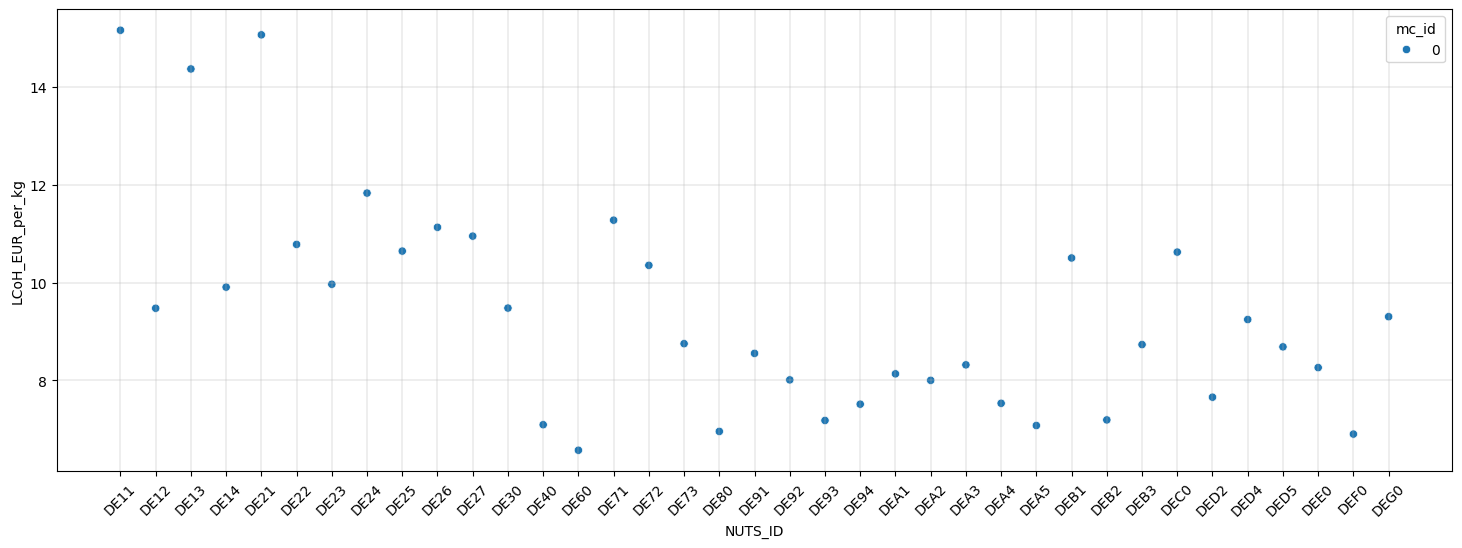

In [218]:
plt.figure(figsize=(18, 6))
sns.scatterplot(data=results_df, x='NUTS_ID', y='LCoH_EUR_per_kg', hue='mc_id')
plt.xticks(rotation=45);
plt.grid(linewidth=0.3)

## maybe faster

In [15]:
import numpy as np

# ---------------- CONFIG ----------------
lifetime = 20
annual_demand_kg = 9_453_600 * 0.6  # target H2 demand per year

# Tech-econ params
elect_capex_per_mw = 2.5e6
elect_opex_per_mw_per_year = 0.03 * elect_capex_per_mw
wind_capex_per_mw = 1.3e6 
wind_opex_per_mw_per_year = 0.03 * wind_capex_per_mw

elect_efficiency_MWhH2_per_MWhe = 0.70
degradation_per_year = 0.01
opex_escalation = 0.015
disc_rate = 0.02

H2_MWh_per_ton = 39.39
H2_MWh_per_kg = H2_MWh_per_ton / 1000.0

H2_MWh_per_ton = 39.39
H2_MWh_per_kg = H2_MWh_per_ton / 1000.0

# Precompute discount factors
df = np.array([1.0 / ((1.0 + disc_rate) ** (t+1)) for t in range(lifetime)])
df_opex = np.array([(1+opex_escalation)**t * df[t] for t in range(lifetime)])
df_deg = np.array([(1-degradation_per_year)**t * df[t] for t in range(lifetime)])
rep_df = df[lifetime // 2]

def optimize_by_duration_curve(wind_profile_unit, max_overbuild=3.0,
                               E_grid_mult=(1.0, 8.0), E_steps=300, tol=1e-6):
    """
    wind_profile_unit: array of hourly values in [0,1], length = 8760.
    Returns dict with optimal E, W and LCoH (same economics as Pyomo).
    """
    s = np.asarray(wind_profile_unit, dtype=float)
    H = len(s)
    s_sorted = np.sort(s)[::-1]              # for fast area calc
    s_cum = np.cumsum(s_sorted)

    # Required electricity (MWh) before electrolyser efficiency
    demand_H2_MWh = annual_demand_kg * H2_MWh_per_kg
    elec_needed_MWh = demand_H2_MWh / elect_efficiency_MWhH2_per_MWhe

    # Quick lower bound on E for feasibility (even with infinite wind -> x = E)
    E_min = elec_needed_MWh / H
    # Reasonable upper bound to explore
    E_lo = E_grid_mult[0] * E_min
    E_hi = E_grid_mult[1] * E_min
    E_grid = np.linspace(E_lo, E_hi, E_steps)

    def sum_min(E, W):
        """ Sum_h min(E, W*s_h) using the sorted profile. """
        if W <= 0: return 0.0
        # threshold t = E/W; count hours where W*s >= E  <=> s >= E/W
        t = E / W
        k = np.count_nonzero(s_sorted >= t)
        # first k hours capped at E; remainder is W*s
        return k * E + W * (s_cum[-1] - (s_cum[k-1] if k > 0 else 0.0))

    def min_W_for_E(E):
        """ Smallest W (<= max_overbuild*E) achieving elec_needed_MWh; None if infeasible. """
        lo, hi = 0.0, max_overbuild * E
        if sum_min(E, hi) + 1e-9 < elec_needed_MWh:
            return None  # infeasible at this E (can’t meet demand even at W cap)
        # bisection
        for _ in range(60):
            mid = 0.5 * (lo + hi)
            if sum_min(E, mid) >= elec_needed_MWh:
                hi = mid
            else:
                lo = mid
            if hi - lo < tol:
                break
        return hi

    # PV multipliers (same as your Pyomo)
    sum_df_opex = float(np.sum(df_opex))
    sum_df_deg  = float(np.sum(df_deg))

    def pv_cost(E, W):
        capex_e = elect_capex_per_mw * E
        capex_w = wind_capex_per_mw * W
        repl_e  = 0.55 * elect_capex_per_mw * E * rep_df
        opex_e  = elect_opex_per_mw_per_year * E * sum_df_opex
        opex_w  = wind_opex_per_mw_per_year  * W * sum_df_opex
        return capex_e + capex_w + repl_e + opex_e + opex_w

    # Denominator of LCoH is constant given your equality constraint:
    PV_H2_kg = annual_demand_kg * sum_df_deg

    best = {"status":"infeasible"}
    for E in E_grid:
        W = min_W_for_E(E)
        if W is None:
            continue
        cost = pv_cost(E, W)
        LCoH = cost / PV_H2_kg
        if (best.get("LCoH_EUR_per_kg") is None) or (LCoH < best["LCoH_EUR_per_kg"]):
            best = {
                "status":"optimal",
                "E_cap_MW": float(E),
                "W_cap_MW": float(W),
                "wind_overbuild_ratio": float(W/E) if E>0 else np.nan,
                "PV_cost_EUR": float(cost),
                "PV_H2_kg": float(PV_H2_kg),
                "LCoH_EUR_per_kg": float(LCoH),
            }
    return best
#example usage

from tqdm import tqdm
import numpy as np
import pandas as pd

all_res = []

for _, row in tqdm(hourly_df.iterrows(), total=hourly_df.shape[0]):
    site_id = f"{row['NUTS_ID']}_{row['mc_id']}"
    
    # Hourly wind profile in MW
    wind_raw = np.array(row["power_MW"], dtype=float)
    
    # Normalize to 0–1 profile
    if wind_raw.max() > 0:
        wind_unit = wind_raw / wind_raw.max()
    else:
        wind_unit = wind_raw   # all zero
    
    # Call the duration-curve optimizer (defined earlier)
    res = optimize_by_duration_curve(wind_unit)
    
    # Add identifiers
    res.update({"NUTS_ID": row["NUTS_ID"], "mc_id": row["mc_id"], "site": site_id})
    all_res.append(res)

results_df2 = pd.DataFrame(all_res)

# Quick look
print(results_df2[["NUTS_ID","mc_id","E_cap_MW","W_cap_MW","LCoH_EUR_per_kg"]].head())


100%|██████████| 18500/18500 [36:47<00:00,  8.38it/s]

  NUTS_ID  mc_id    E_cap_MW    W_cap_MW  LCoH_EUR_per_kg
0    DE11      0  116.620005  347.451302        15.171818
1    DE11      1   79.087130  187.396360         9.137004
2    DE11      2   86.764309  223.100107        10.442217
3    DE11      3   78.234110  178.454352         8.873162
4    DE11      4   85.058269  220.494920        10.279444


In [221]:
results_df2.to_clipboard()

In [16]:
results_df2.to_parquet(r"C:\Users\mun93\My_VS_codes\\Resource_Assessment_VS\LCoH_mc_results_calcuations.parquet")

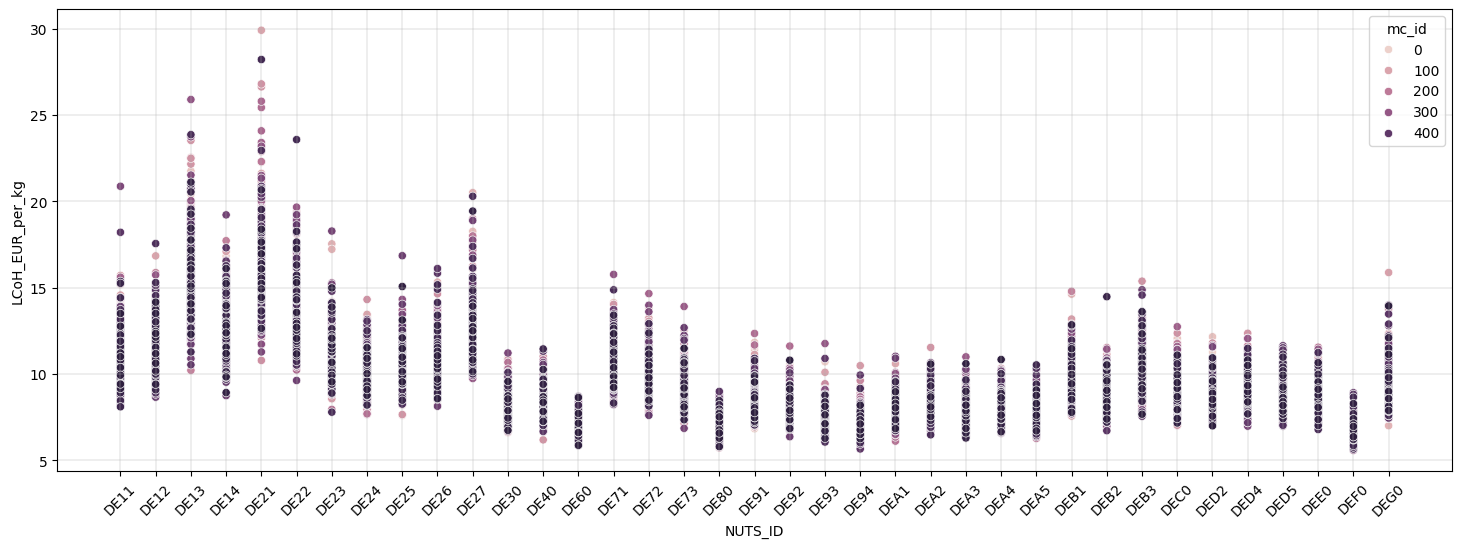

In [17]:
plt.figure(figsize=(18, 6))
sns.scatterplot(data=results_df2, x='NUTS_ID', y='LCoH_EUR_per_kg', hue='mc_id')
plt.xticks(rotation=45);
plt.grid(linewidth=0.3)

C:\Users\mun93\AppData\Local\Temp\ipykernel_1712\3695362551.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


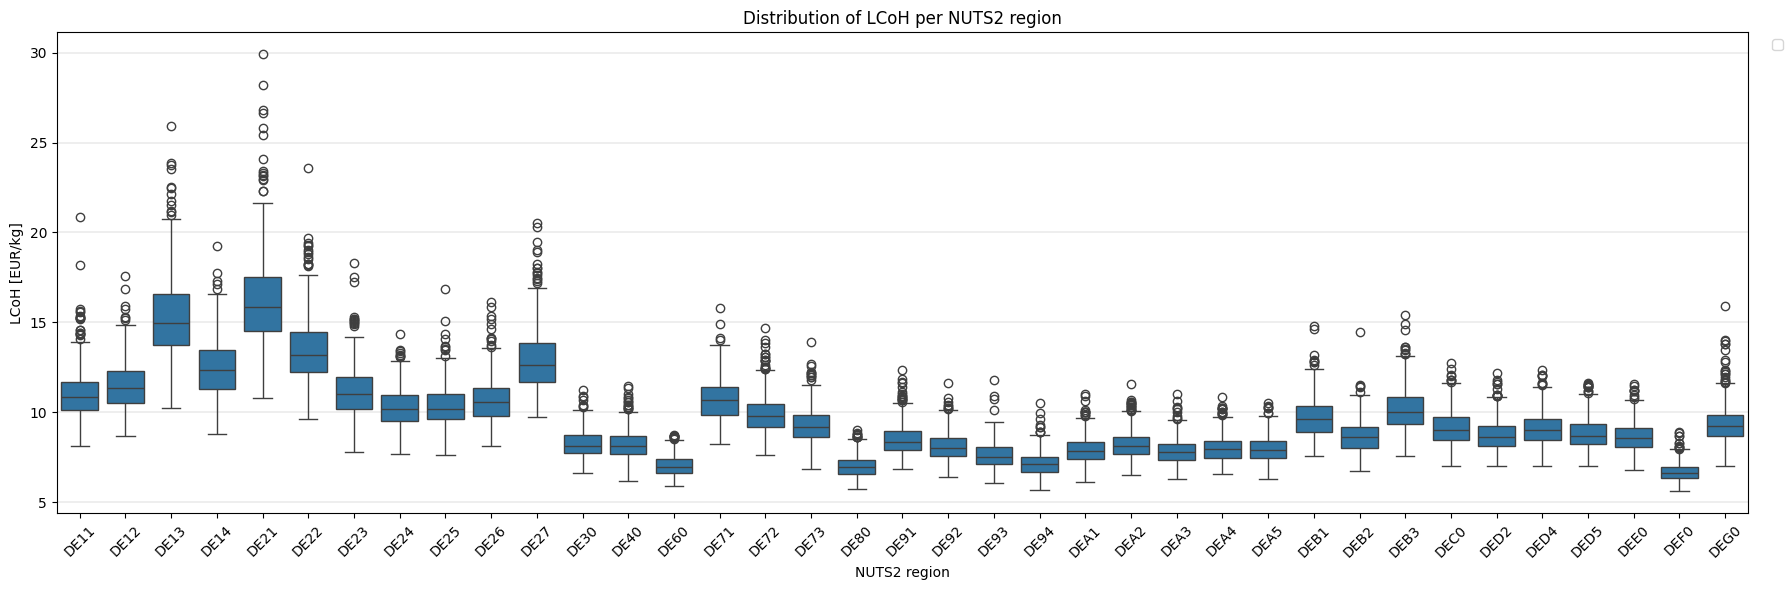

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
sns.boxplot(
    data=results_df2,
    x="NUTS_ID",
    y="LCoH_EUR_per_kg",
    #showfliers=False,   # hide outliers if you want cleaner boxes
)
# sns.stripplot(           # optional: add jittered points to see distribution
#     data=results_df2,
#     x="NUTS_ID",
#     y="LCoH_EUR_per_kg",
#     hue="mc_id",
#     dodge=True,
#     alpha=0.6,
#     size=4
# )

plt.xticks(rotation=45)
plt.grid(linewidth=0.3, axis="y")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.ylabel("LCoH [EUR/kg]")
plt.xlabel("NUTS2 region")
plt.title("Distribution of LCoH per NUTS2 region")
plt.tight_layout()
plt.show()


## solve for 20 years

In [158]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# ---------------- CONFIG ----------------
LIFETIME = 20
HOURS_YR = 8760
H2_MWh_per_kg = 39.39/1000.0
ETA = 0.70                       # electrolyser MWh_H2 per MWh_e
OVERBUILD_MAX = 3.0              # W <= OVERBUILD_MAX * E

# simple cost model (edit as needed)
CAPEX_E = 2.5e6                  # €/MW electrolyser
CAPEX_W = 1.3e6                  # €/MW wind
OPEX_E_Y = 0.03 * CAPEX_E        # €/MW/y
OPEX_W_Y = 0.03 * CAPEX_W        # €/MW/y
DISC = 0.02
OESC = 0.015
REP_RATE_E = 0.55                # electrolyser mid-life replacement fraction

def pv_factor_series(lifetime, disc):
    years = np.arange(1, lifetime+1)
    df = 1.0/((1.0+disc)**years)
    return df

def pv_opex_sum(lifetime, disc, oesc):
    years = np.arange(1, lifetime+1)
    df = 1.0/((1.0+disc)**years)
    df_opex = ((1.0+oesc)**(years-1)) * df
    return float(df_opex.sum())

def duration_bins_year(s_year, n_bins=120):
    """
    Area-preserving duration-curve compression for one year.
    Returns within-bin mean levels s_bin and counts (hours) n_bin.
    """
    s = np.asarray(s_year, float)
    if s.size == 0 or s.max() <= 0:
        return np.array([]), np.array([])
    # quantile index breaks (equal-count bins)
    idx = np.linspace(0, s.size, n_bins+1, dtype=int)
    s_sorted = np.sort(s)  # ascending
    s_means, counts = [], []
    for i in range(n_bins):
        lo, hi = idx[i], idx[i+1]
        if hi <= lo: 
            continue
        chunk = s_sorted[lo:hi]
        s_means.append(float(chunk.mean()))
        counts.append(float(len(chunk)))
    s_bins = np.array(s_means, float)
    cnts   = np.array(counts, float)
    keep = (cnts > 0) & (s_bins > 0)
    return s_bins[keep], cnts[keep]

def build_binned_dataset_20y(wind_profile_20y_MW, n_bins=120):
    """
    Split the 20-year hourly profile to 20 years, normalize each year by the global max,
    and build per-year duration bins (s_tb, n_tb).
    """
    assert wind_profile_20y_MW.size == LIFETIME*HOURS_YR, "Expect 20*8760 values."
    Wmat = wind_profile_20y_MW.reshape(LIFETIME, HOURS_YR)
    max_power = wind_profile_20y_MW.max()
    if max_power <= 0:
        return None
    S = Wmat / max_power  # unit availability
    per_year = []
    for t in range(LIFETIME):
        s_bins, counts = duration_bins_year(S[t], n_bins=n_bins)
        per_year.append((s_bins, counts))
    return per_year

def optimize_durationcurve_LP_20y(wind_profile_20y_MW,
                                  H2_kg_per_year=5000.0*5,
                                  n_bins=120,
                                  overbuild=OVERBUILD_MAX):
    """
    Duration-curve LP across 20 years (bins per year).
    Min CAPEX+PV(OPEX) subject to meeting the annual H2 demand in EACH year.
    """
    per_year = build_binned_dataset_20y(wind_profile_20y_MW, n_bins=n_bins)
    if per_year is None: 
        return {"status":"infeasible", "reason":"zero_wind"}

    # economics (present value)
    df = pv_factor_series(LIFETIME, DISC)
    rep_df = df[LIFETIME//2 - 1]
    pv_opex = pv_opex_sum(LIFETIME, DISC, OESC)

    demand_MWhH2 = H2_kg_per_year * H2_MWh_per_kg  # per year

    # ----- Pyomo model -----
    m = pyo.ConcreteModel()
    m.T = pyo.RangeSet(0, LIFETIME-1)
    # different bin cardinality per year → build a flattened index (t,b)
    TB = []
    for t in range(LIFETIME):
        s_bins, counts = per_year[t]
        for b in range(len(s_bins)):
            TB.append((t, b))
    m.TB = pyo.Set(initialize=TB, dimen=2)

    # store per-year per-bin params
    s_dict = {(t,b): float(per_year[t][0][b]) for (t,b) in TB}
    n_dict = {(t,b): float(per_year[t][1][b]) for (t,b) in TB}
    m.s = pyo.Param(m.TB, initialize=s_dict)
    m.n = pyo.Param(m.TB, initialize=n_dict)

    # decision vars
    m.E = pyo.Var(within=pyo.NonNegativeReals)     # electrolyser MW
    m.W = pyo.Var(within=pyo.NonNegativeReals)     # wind MW
    m.p = pyo.Var(m.TB, within=pyo.NonNegativeReals)  # per-bin power (MW) in that year

    # constraints
    m.overbuild = pyo.Constraint(expr=m.W <= overbuild * m.E)
    m.cap_con   = pyo.Constraint(m.TB, rule=lambda m,t,b: m.p[t,b] <= m.E)
    m.wind_con  = pyo.Constraint(m.TB, rule=lambda m,t,b: m.p[t,b] <= m.W * m.s[t,b])

    # annual H2 requirement (each year)
    def annual_req(m, t):
        elec_t = pyo.quicksum(m.n[t,b] * m.p[t,b] for b in range(len(per_year[t][0])))
        return ETA * elec_t >= demand_MWhH2
    m.req = pyo.Constraint(m.T, rule=annual_req)

    # objective: PV of costs
    pv_cost = (CAPEX_E*m.E + CAPEX_W*m.W
               + REP_RATE_E*CAPEX_E*m.E*rep_df
               + OPEX_E_Y*m.E*pv_opex
               + OPEX_W_Y*m.W*pv_opex)
    m.obj = pyo.Objective(expr=pv_cost, sense=pyo.minimize)

    # solve
    opt = SolverFactory("gurobi")
    opt.options.update({"Method":1, "Presolve":2, "Crossover":0, "OutputFlag":0,
                        "FeasibilityTol":1e-6, "OptimalityTol":1e-6})
    res = opt.solve(m)
    if res.solver.termination_condition != pyo.TerminationCondition.optimal:
        return {"status":"infeasible", "solver": str(res.solver.termination_condition)}

    # extract + simple diagnostics
    E = pyo.value(m.E); W = pyo.value(m.W)
    # annual dispatch (base-year-like, sum over all years/bins)
    ann_elec = []
    for t in range(LIFETIME):
        val = sum(pyo.value(m.n[t,b] * m.p[t,b]) for b in range(len(per_year[t][0])))
        ann_elec.append(val)
    ann_elec = np.array(ann_elec, float)

    return {
        "status":"optimal",
        "E_cap_MW": float(E),
        "W_cap_MW": float(W),
        "wind_overbuild_ratio": float(W/E) if E>0 else np.nan,
        "annual_elec_MWh": ann_elec,                # length = 20
        "meets_all_years": bool((ETA*ann_elec >= demand_MWhH2 - 1e-6).all()),
        "PV_cost_EUR": float(pyo.value(pv_cost)),
        "LCoH_EUR_per_kg": float(pyo.value(pv_cost) / (H2_kg_per_year * sum(df_deg)))

    }


from tqdm import tqdm

all_results = []
for _, row in tqdm(twenty_year_hourly_df.iterrows(), total=len(twenty_year_hourly_df)):
    wind_prof = np.array(row["power_MW"], dtype=float)  # length = 20*8760
    res = optimize_durationcurve_LP_20y(wind_prof, overbuild=10, H2_kg_per_year=5000.0, n_bins=60)
    res.update({
        "NUTS_ID": row["NUTS_ID"],
        "mc_id": row["mc_id"]
    })
    all_results.append(res)

results_df = pd.DataFrame(all_results)
results_df

  0%|          | 0/18500 [00:00<?, ?it/s]

100%|██████████| 18500/18500 [1:36:54<00:00,  3.18it/s]  


,status,E_cap_MW,W_cap_MW,wind_overbuild_ratio,annual_elec_MWh,meets_all_years,PV_cost_EUR,LCoH_EUR_per_kg,NUTS_ID,mc_id
0,optimal,0.093248,0.326694,3.503495,"[281.3571428571428, 281.35714285714266, 281.35...",True,1.132459e+06,15.113824,DE11,0
1,optimal,0.074889,0.201563,2.691477,"[281.3571428571432, 281.3571428571433, 281.357...",True,7.860446e+05,10.490571,DE11,1
2,optimal,0.088896,0.279010,3.138615,"[281.3571428571431, 281.3571428571431, 281.357...",True,1.013753e+06,13.529574,DE11,2
3,optimal,0.083450,0.232241,2.783004,"[281.35714285714283, 281.3571428571427, 281.35...",True,8.914017e+05,11.896669,DE11,3
4,optimal,0.078902,0.230516,2.921546,"[281.35714285714295, 281.35714285714295, 281.3...",True,8.650165e+05,11.544531,DE11,4
...,...,...,...,...,...,...,...,...,...,...
18495,optimal,0.065508,0.150492,2.297289,"[281.35714285714283, 281.35714285714283, 281.3...",True,6.351592e+05,8.476850,DEG0,495
18496,optimal,0.065473,0.151833,2.319014,"[281.3571428571427, 281.3571428571427, 281.357...",True,6.377038e+05,8.510810,DEG0,496
18497,optimal,0.067755,0.161511,2.383746,"[281.35714285714306, 281.35714285714306, 281.3...",True,6.688357e+05,8.926298,DEG0,497
18498,optimal,0.076739,0.214810,2.799211,"[281.35714285714283, 281.35714285714295, 281.3...",True,8.222474e+05,10.973734,DEG0,498


C:\Users\mun93\AppData\Local\Temp\ipykernel_1712\3681697429.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")


<Figure size 1600x400 with 0 Axes>

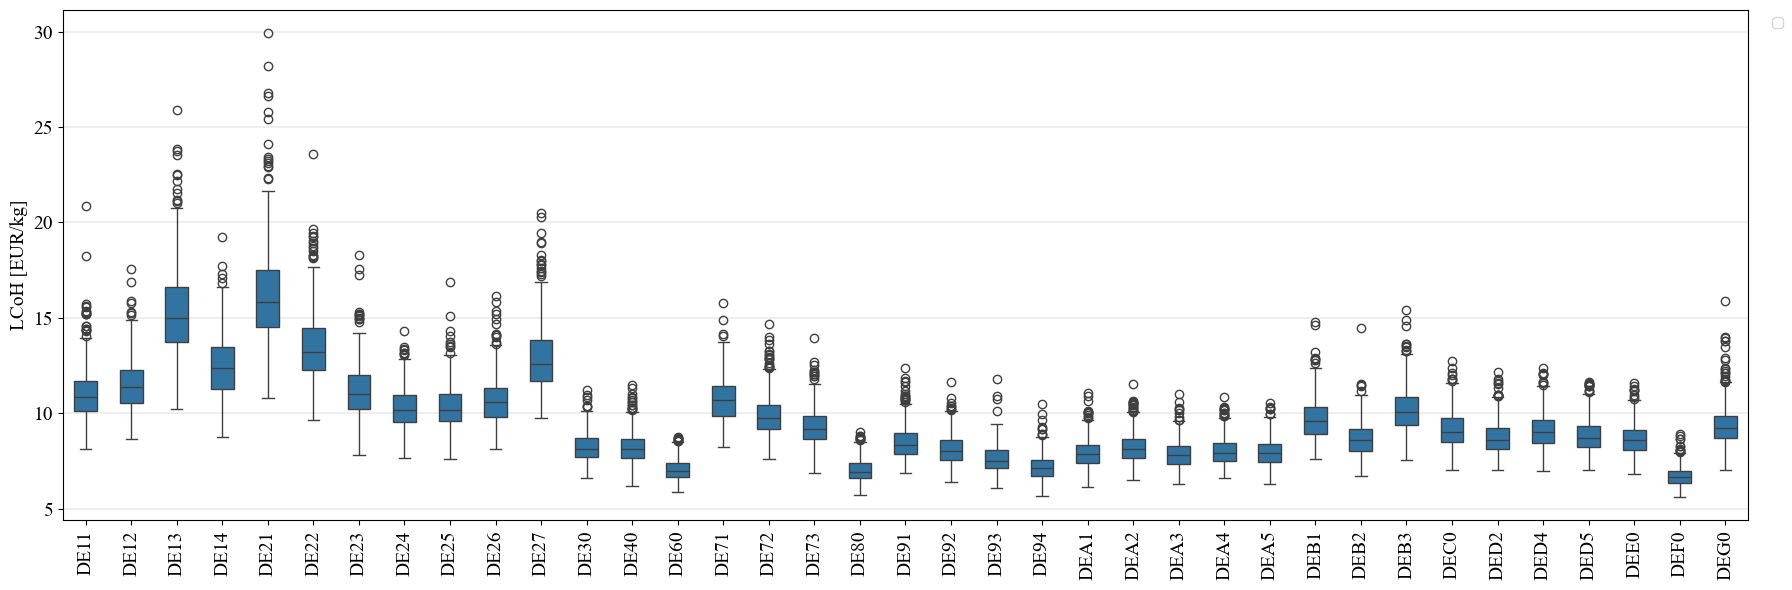

In [173]:
plt.figure(figsize=(16, 4))
plt.rcParams["font.family"] = "Times New Roman"

#sns.scatterplot(data=results_df, x="NUTS_ID", y="LCoH_EUR_per_kg", s=40);plt.xticks(rotation=90);plt.grid()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
sns.boxplot(
    data=results_df2,
    x="NUTS_ID",
    y="LCoH_EUR_per_kg",
    width=0.5,
    #showfliers=False,   # hide outliers if you want cleaner boxes
)
# sns.stripplot(           # optional: add jittered points to see distribution
#     data=results_df2,
#     x="NUTS_ID",
#     y="LCoH_EUR_per_kg",
#     hue="mc_id",
#     dodge=True,
#     alpha=0.6,
#     size=4
# )

plt.xticks(rotation=90, fontsize=14); plt.yticks(fontsize=14);
plt.grid(linewidth=0.3, axis="y")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.ylabel("LCoH [EUR/kg]", fontsize=14)
plt.xlabel('')
#plt.title("Distribution of LCoH per NUTS2 region")
plt.tight_layout()
plt.show()


In [159]:
results_df.to_parquet(r"C:\Users\mun93\My_VS_codes\\Resource_Assessment_VS\twenty_year_LCoH_mc_results_calcuations.parquet")

## supply curve

In [175]:
lcoh_df = pd.read_parquet(r'C:\Users\mun93\My_VS_codes\\Resource_Assessment_VS\twenty_year_LCoH_mc_results_calcuations.parquet')
h2_mc_df = pd.read_csv(r'C:\Users\mun93\OneDrive\PhD\Research Proposal\Project_2\h2_mc_df.csv')
h2_mc_df.head()

,NUTS_ID,outer_sample,h2_TWh,h2_Mt,pd_scaled,efficiency,electrolyser_efficiency,availability,spacing,scale_perturbed,epsilon
0,DE11,0,0.249963,0.006346,197.119237,0.366426,0.721624,0.886140,8.264792,258.110219,1.068003
1,DE11,1,0.415841,0.010557,181.074267,0.363450,0.758681,0.903743,6.333513,237.100748,0.981071
2,DE11,2,0.463013,0.011755,200.934138,0.385425,0.782902,0.900656,6.602959,263.105494,1.088673
3,DE11,3,0.504435,0.012806,223.052725,0.370575,0.751890,0.885658,6.351188,292.067829,1.208512
4,DE11,4,0.463814,0.011775,178.651291,0.376671,0.782462,0.888819,6.107395,233.928075,0.967943


In [ ]:
lcoh_short = lcoh_df[['NUTS_ID', 'LCoH_EUR_per_kg']]
h2_production_short = h2_mc_df[['NUTS_ID', 'h2_Mt']]

,status,E_cap_MW,W_cap_MW,wind_overbuild_ratio,annual_elec_MWh,meets_all_years,PV_cost_EUR,LCoH_EUR_per_kg,NUTS_ID,mc_id
0,optimal,0.093248,0.326694,3.503495,"[281.3571428571428, 281.35714285714266, 281.35...",True,1.132459e+06,15.113824,DE11,0
1,optimal,0.074889,0.201563,2.691477,"[281.3571428571432, 281.3571428571433, 281.357...",True,7.860446e+05,10.490571,DE11,1
2,optimal,0.088896,0.279010,3.138615,"[281.3571428571431, 281.3571428571431, 281.357...",True,1.013753e+06,13.529574,DE11,2
3,optimal,0.083450,0.232241,2.783004,"[281.35714285714283, 281.3571428571427, 281.35...",True,8.914017e+05,11.896669,DE11,3
4,optimal,0.078902,0.230516,2.921546,"[281.35714285714295, 281.35714285714295, 281.3...",True,8.650165e+05,11.544531,DE11,4
...,...,...,...,...,...,...,...,...,...,...
18495,optimal,0.065508,0.150492,2.297289,"[281.35714285714283, 281.35714285714283, 281.3...",True,6.351592e+05,8.476850,DEG0,495
18496,optimal,0.065473,0.151833,2.319014,"[281.3571428571427, 281.3571428571427, 281.357...",True,6.377038e+05,8.510810,DEG0,496
18497,optimal,0.067755,0.161511,2.383746,"[281.35714285714306, 281.35714285714306, 281.3...",True,6.688357e+05,8.926298,DEG0,497
18498,optimal,0.076739,0.214810,2.799211,"[281.35714285714283, 281.35714285714295, 281.3...",True,8.222474e+05,10.973734,DEG0,498


In [ ]:
summary = merged.groupby("NUTS_ID").agg(
    lcoh_min=("LCoH_EUR_per_kg", "min"),
    lcoh_med=("LCoH_EUR_per_kg", "median"),
    lcoh_max=("LCoH_EUR_per_kg", "max"),
    vol_min=("h2_Mt", "min"),
    vol_med=("h2_Mt", "median"),
    vol_max=("h2_Mt", "max"),
).reset_index()
